/var/folders/cp/l_nj7m8d1vbcnqdgjq_mg5_80000gn/T/ipykernel_32500/3814668438.py:116: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


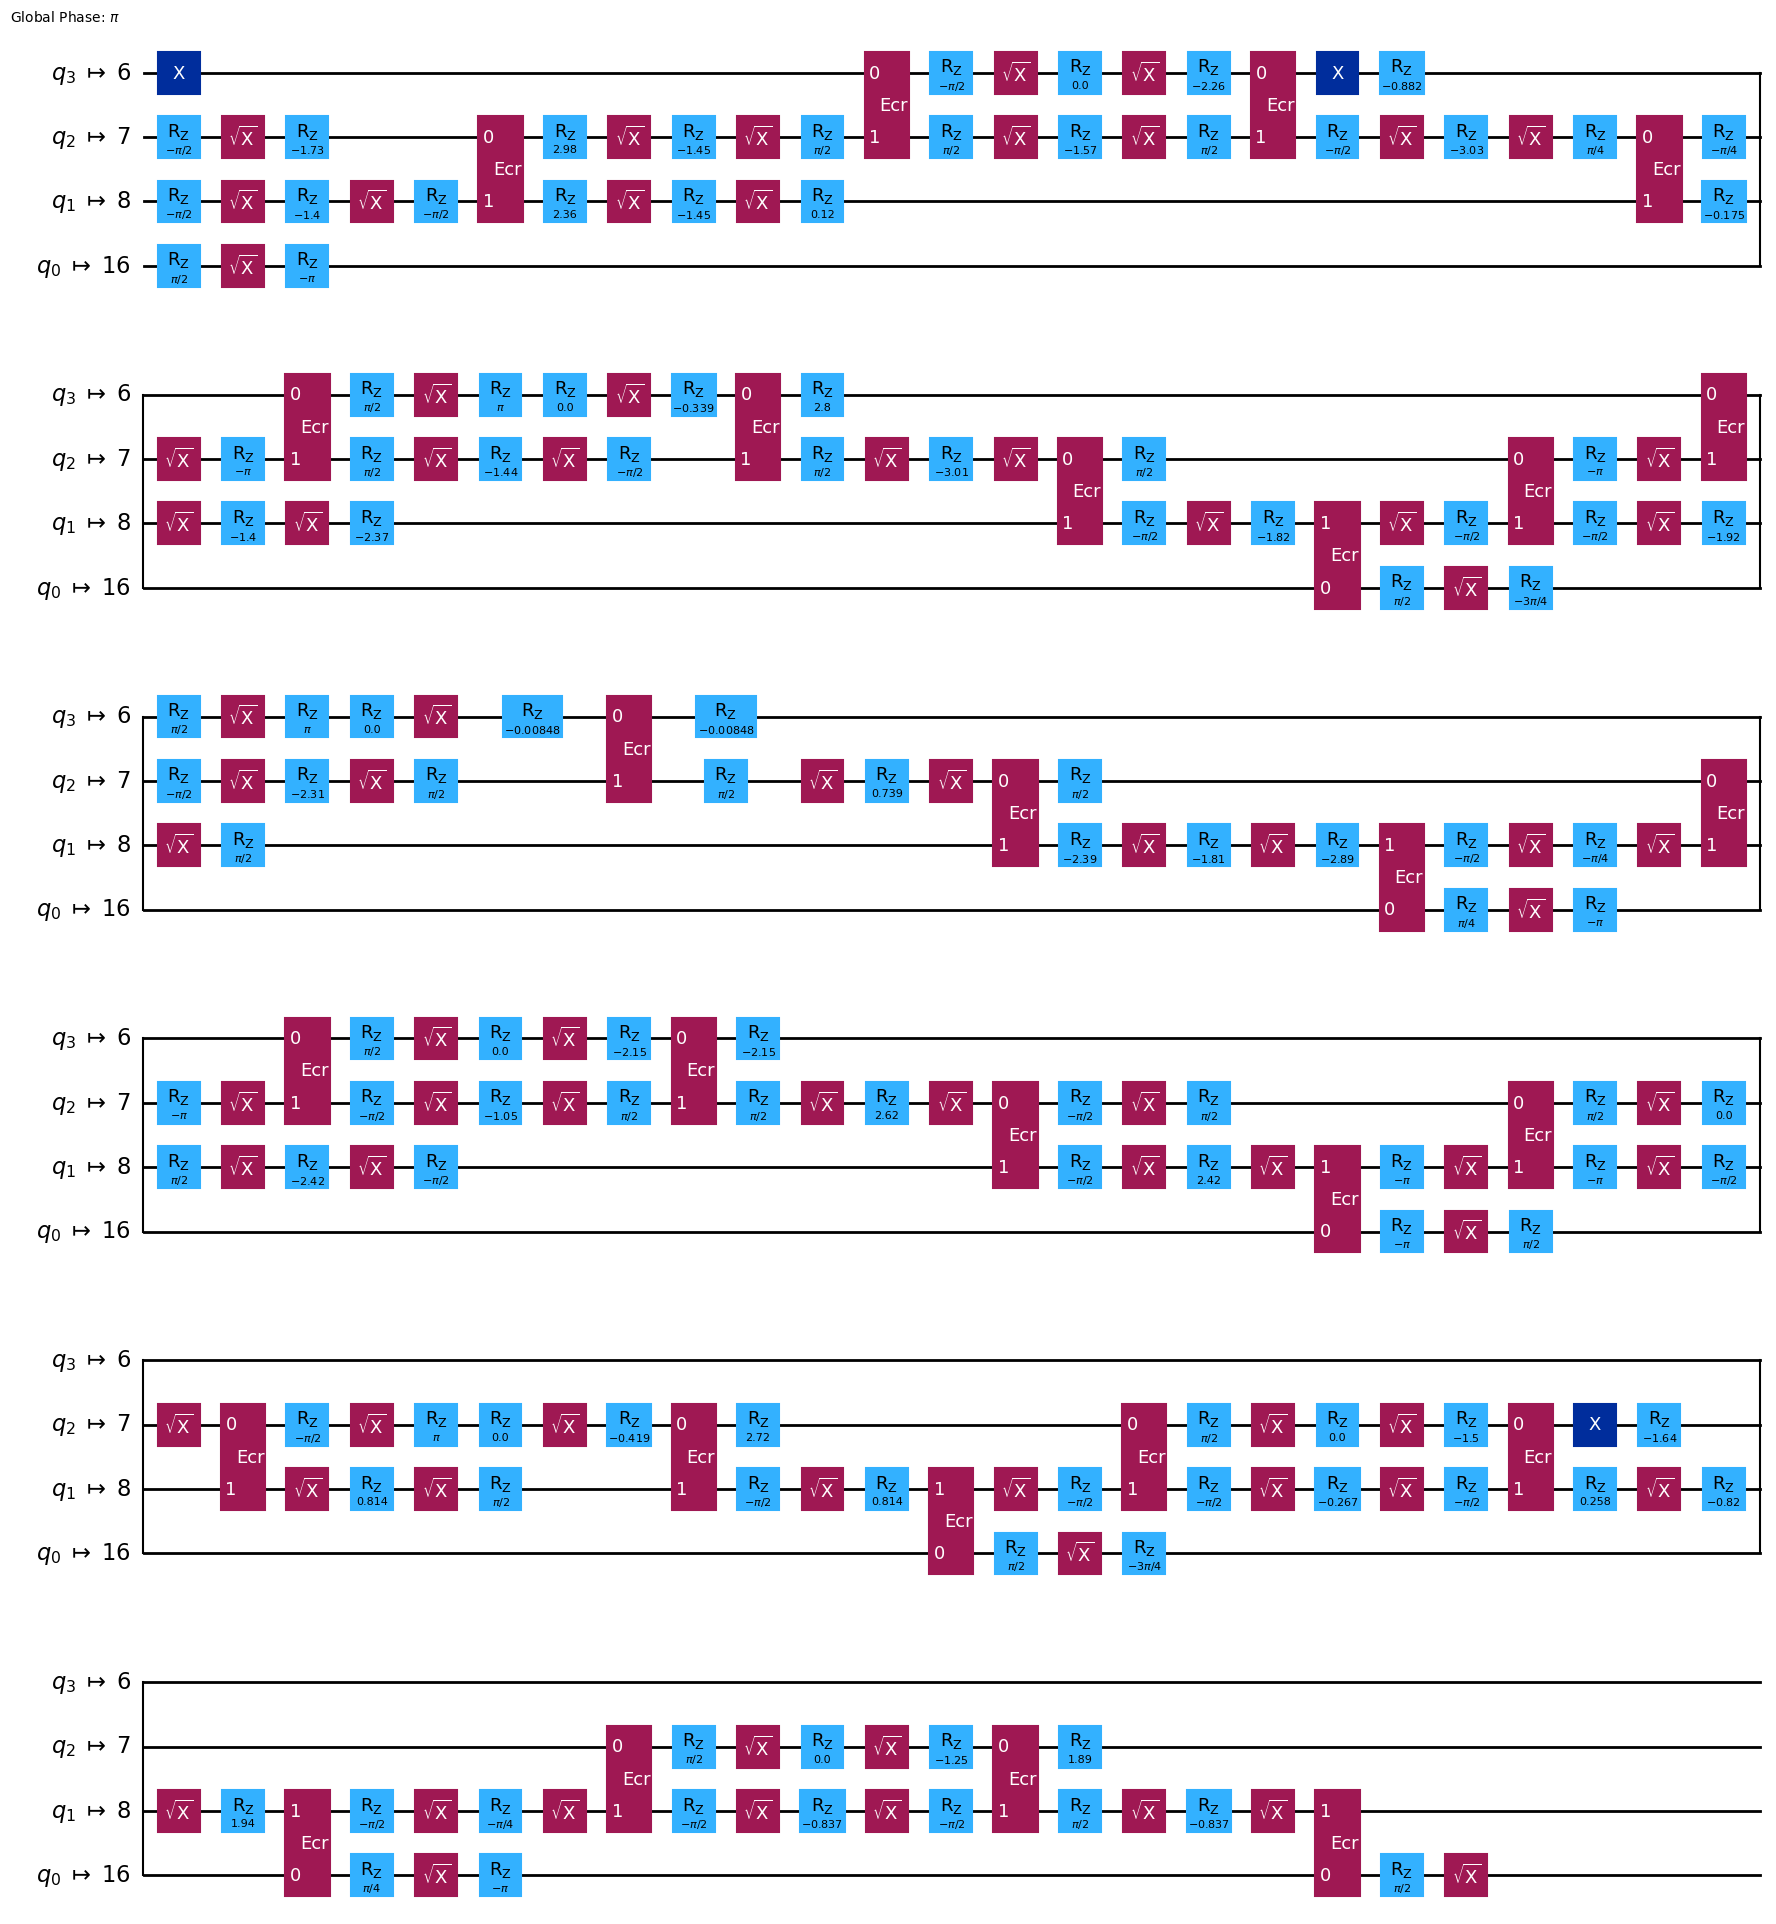

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from itertools import combinations
import numpy as np

def generate_singles(occ, virt):
    return [(i, a) for i in occ for a in virt]

def generate_doubles(occ, virt):
    return [(i, j, a, b)
            for i, j in combinations(occ, 2)
            for a, b in combinations(virt, 2)]

def jw_single_excitation(i, a, n_qubits):
    """
    Return Pauli strings (Z..Z X..X Y..Y etc.) for a†_a a_i - h.c.
    """
    ops = []

    z_string = ['I'] * n_qubits
    for k in range(min(i, a)+1, max(i, a)):
        z_string[k] = 'Z'

    if i < a:
        label1 = z_string.copy()
        label1[i] = 'Y'
        label1[a] = 'X'
        ops.append((''.join(reversed(label1)), 0.5j))

        label2 = z_string.copy()
        label2[i] = 'X'
        label2[a] = 'Y'
        ops.append((''.join(reversed(label2)), -0.5j))

    else:
        label1 = z_string.copy()
        label1[a] = 'Y'
        label1[i] = 'X'
        ops.append((''.join(reversed(label1)), -0.5j))

        label2 = z_string.copy()
        label2[a] = 'X'
        label2[i] = 'Y'
        ops.append((''.join(reversed(label2)), 0.5j))

    return ops

def apply_pauli_rotation(qc, label, theta):
    """
    Apply exp(-i * theta * P) to the circuit, where P is a Pauli string.
    """
    n = len(label)
    # Step 1: basis change
    for i in range(n):
        if label[i] == 'X':
            qc.h(i)
        elif label[i] == 'Y':
            qc.sdg(i)
            qc.h(i)
        # 'Z' and 'I' are fine

    # Step 2: CNOT ladder
    qubits = [i for i, p in enumerate(label) if p != 'I']
    for i in range(len(qubits)-1):
        qc.cx(qubits[i], qubits[i+1])

    # Step 3: Rz rotation
    qc.rz(2 * theta, qubits[-1])

    # Step 4: Undo CNOTs
    for i in reversed(range(len(qubits)-1)):
        qc.cx(qubits[i], qubits[i+1])

    # Step 5: Undo basis change
    for i in range(n):
        if label[i] == 'X':
            qc.h(i)
        elif label[i] == 'Y':
            qc.h(i)
            qc.s(i)

def build_manual_uccsd(n_qubits, occ, virt):
    qc = QuantumCircuit(n_qubits)

    # HF reference state
    for i in occ:
        qc.x(i)

    singles = generate_singles(occ, virt)
    param_index = 0

    for (i, a) in singles:
        pauli_terms = jw_single_excitation(i, a, n_qubits)
        theta = Parameter(f"θ_{param_index}")
        for label, coeff in pauli_terms:
            apply_pauli_rotation(qc, label, coeff.real * theta)
        param_index += 1

    # TODO: Add double excitations too (optional step)

    return qc

n_qubits = 4
occupied = [0, 1]
virtual = [2, 3]

uccsd = build_manual_uccsd(n_qubits, occupied, virtual)
uccsd.draw('mpl')

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

qc = build_manual_uccsd(n_qubits, occupied, virtual)

backend_name = "ibm_brisbane" #we can change this
service = QiskitRuntimeService()
backend = service.backend(backend_name)
pm = generate_preset_pass_manager(backend=backend, optimization_level=3) #we can change the optimization level to match what our algorithm is capable of
qc_transpiled = pm.run(qc)

qc_transpiled.draw('mpl')